# K-Means and PCA

## Overview

In this lab, we will experiment with the K-Means clustering algorithm.  This will lead naturally to the need for dimensionality reduction.  We will think about manual approaches and use Principal Component Analysis (PCA) to reduce the dimensionality of the data down to something that we can easily visualize.  The lingering problem of determining the number of clusters algorithmically will remain at the conclusion of this lab.

## Goals

As a result of the activities in this lab, you will be able to:

* Use the K-Means clustering algorithm
* Understand better how to organize your data for use with clustering algorithms
* Understand better how to normalize data
* Understand why normalization can be important
* Understand how and when to use PCA
* Examine the benefits of scaling data

 
## Estimated Time: 30 - 45 minutes

We will start with a very simple dataset in this lab and progress to a more complex dataset once we have a firm grasp on the principles.  As we work through this lab, try to keep focused on the end-goal: Examine a useful mechanism for identifying similarities in our data.

Finding similarities in our data is precisely what unsupervised clustering algorithms do.  In fact, thinking about this, it should be obvious why these are unsupervised machine learning methods.  If we knew how many clusters there should be and what those clusters should represent, we would be looking at a supervised classification problem.

Since these clustering tools are primarily used for finding and beginning to understand relationships in our data, we very much view these as data exploration tools rather than solutions.  In other words, from our perspective clustering methods are a useful stop along the journey from acquiring data to presenting useful representations of information that can be used for decision making.

# <img src="../images/task.png" width=20 height=20> Task 1.1

The first things that we need to do are to import our libraries.  This lab will make use of Numpy, Pandas, and Matplotlib.  You should import all of these using the typical aliases in the next cell.


The clustering tools that we will use in our exercises today are found in the Scikit-Learn library, which has the package name `sklearn`.  Please import the following from `sklearn`:

* From the `cluster` branch in `sklearn`, please import `KMeans`
* From the `decomposition` branch, please import `PCA`

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data for these labs can be found in `../data/Day 3/`.  For this first portion of the lab, we will work with the `conn.log` file found in this directory.

This file is a log of the connections recorded by Zeek or Corelight, a network intelligence framework tool.  The files are tab delimited files, with the first eight rows comprising header and other structural information.  The log of the connections themselves follow these first eight lines.

# <img src="../images/task.png" width=20 height=20> Task 1.2

Examine the `../data/Day 3/conn.log` file.  Within the header, locate and determine the names of the various columns.  Armed with this information, use the following cell to load this file into a Pandas dataframe with reasonable names for the columns.

*Hint:* You can load a file and assign column names in Pandas using `pd.read_csv(filename, names=['column', 'names', 'here'])`.

**Note:** You will most likely see a warning about mixed types in the loaded data.  This is completely expected and can be ignored safely.

In [2]:
cols =['timestamp','uid','src','sport','dst','dport','proto','service','duration','orig_bytes', 
               'resp_bytes','conn_state','local_orig','local_resp','missed_bytes','history','orig_pkts', 
               'orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents']

df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8,names=cols)

df.head(5)

/tmp/ipykernel_13942/1438706720.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8,names=cols)


,timestamp,uid,src,sport,dst,dport,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,1556714128.491209,Chmpt162NcHAq0YCb,192.168.61.20,50885.0,104.81.135.169,80.0,tcp,http,0.373957,213,...,SF,-,-,0.0,ShADadfF,6.0,465.0,8.0,4989.0,-
1,1556714133.054463,CP1SQx2NHC8s9Z0CBi,192.168.61.20,50883.0,64.4.54.165,443.0,tcp,-,0.058941,0,...,REJ,-,-,0.0,FRr,2.0,80.0,1.0,40.0,-
2,1556714128.452636,CuBvgmZmRctyexTO7,192.168.50.25,50074.0,8.8.8.8,53.0,udp,dns,0.036838,63,...,SF,-,-,0.0,Dd,1.0,91.0,1.0,196.0,-
3,1556714174.956009,CBRo9C4lGZ28ds6kSj,192.168.50.25,49869.0,8.8.8.8,53.0,udp,dns,0.014214,40,...,SF,-,-,0.0,Dd,1.0,68.0,1.0,143.0,-
4,1556714176.179854,CAnMKM3FVungeQbAci,192.168.50.25,51367.0,8.8.8.8,53.0,udp,dns,0.113166,71,...,SF,-,-,0.0,Dd,1.0,99.0,1.0,161.0,-


If you peruse the data, there are some things that need some cleaning up.  For example, the final row in the data isn't really a row of data.  Additionally, the protocol and service fields are definitely categorical data, currently encoded as strings.  Let's deal with this first.

Pandas allows you to easily convert a categorical field into a set of one-hot encoded columns using the `get_dummies()` convenience method.

```
get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, 
    sparse=False, drop_first=False, dtype=None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.
    
    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a dictionary mapping column names to prefixes.
    prefix_sep : str, default '_'
        If appending prefix, separator/delimiter to use. Or pass a
        list or dictionary as with `prefix`.
    dummy_na : bool, default False
        Add a column to indicate NaNs, if False NaNs are ignored.
    columns : list-like, default None
        Column names in the DataFrame to be encoded.
        If `columns` is None then all the columns with
        `object` or `category` dtype will be converted.
    sparse : bool, default False
        Whether the dummy-encoded columns should be backed by
        a :class:`SparseArray` (True) or a regular NumPy array (False).
    drop_first : bool, default False
        Whether to get k-1 dummies out of k categorical levels by removing the
        first level.
    dtype : dtype, default np.uint8
        Data type for new columns. Only a single dtype is allowed.
    
        .. versionadded:: 0.23.0
    
    Returns
    -------
    DataFrame
        Dummy-coded data.
    
    See Also
    --------
    Series.str.get_dummies : Convert Series to dummy codes.
    
    Examples
    --------
    >>> s = pd.Series(list('abca'))
    
    >>> pd.get_dummies(s)
       a  b  c
    0  1  0  0
    1  0  1  0
    2  0  0  1
    3  1  0  0
```

# <img src="../images/task.png" width=20 height=20> Task 1.3

Please use the `get_dummies()` function to convert the protocol column into a set of one-hot encoded columns.

In [3]:
df = pd.concat([df, pd.get_dummies(df['proto'], prefix='proto')], axis=1)
df.head(5)

,timestamp,uid,src,sport,dst,dport,proto,service,duration,orig_bytes,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,proto_icmp,proto_tcp,proto_udp
0,1556714128.491209,Chmpt162NcHAq0YCb,192.168.61.20,50885.0,104.81.135.169,80.0,tcp,http,0.373957,213,...,0.0,ShADadfF,6.0,465.0,8.0,4989.0,-,False,True,False
1,1556714133.054463,CP1SQx2NHC8s9Z0CBi,192.168.61.20,50883.0,64.4.54.165,443.0,tcp,-,0.058941,0,...,0.0,FRr,2.0,80.0,1.0,40.0,-,False,True,False
2,1556714128.452636,CuBvgmZmRctyexTO7,192.168.50.25,50074.0,8.8.8.8,53.0,udp,dns,0.036838,63,...,0.0,Dd,1.0,91.0,1.0,196.0,-,False,False,True
3,1556714174.956009,CBRo9C4lGZ28ds6kSj,192.168.50.25,49869.0,8.8.8.8,53.0,udp,dns,0.014214,40,...,0.0,Dd,1.0,68.0,1.0,143.0,-,False,False,True
4,1556714176.179854,CAnMKM3FVungeQbAci,192.168.50.25,51367.0,8.8.8.8,53.0,udp,dns,0.113166,71,...,0.0,Dd,1.0,99.0,1.0,161.0,-,False,False,True


With that completed, we're ready to do a little bit more preprocessing and data cleaning.  Here's what we'd like to do:

* Remove the last row of the dataframe since it isn't really data
* Get rid of some columns that seem as though they might be irrelevant to clustering our data

When we want to remove rows or columns, we can use the `drop()` function.  This function allows us to pass a list of row indices that we would like to remove from our dataframe.  Alternatively, we can pass a keyword argument *columns* with a list of column names that we would like to remove.  To save a bit of memory and make things simpler, we can also pass the keyword argument `inplace=True` to make the changes to the existing dataframe rather than creating a new dataframe.

Deleting a row, then, is easy, and it is obvious why that row should be removed.  How about deleting columns?  Which columns don't seem useful?  To answer that, let's think about a goal in clustering this data.

## Selecting Features

It is important to realize that we are engaging in an experiment.  There truly is no "right" set of features to use to generate clusters from data.  The only thing that determines if our approach is correct is whether the outputs are useful.  With this said, we are now going to prune away some features in an effort to reduce the number of features and the amount of adjusting we need to do to the data before doing the clustering.

If we theorize that normal communications will have different clusters based on which applications are used and that anomalous communications would probably have different clustering, we can imagine that we are probably interested in keeping information about connections that is relevant to the length of the communication, the number of bytes sent, the protocol in use, the number of packets, the port numbers...  But some of the fields would be less useful.

For example, while the source address is interesting, retaining the source address (or the entire source address) seems less useful when thinking of clustering the data in terms of what the communication is doing.  Similarly, the timestamp might be very useful if we are looking for temporal clusters, or if time would be related to the clusters, but for now that relationship doesn't seem important.  Therefore, let's select some columns to exclude.

# <img src="../images/task.png" width=20 height=20> Task 1.4

Use the following cell to:

* Drop the final row of the dataframe
* Discard the source, protocol, destination, timestamp, missed bytes, UID, service, local_orig, local_resp, tunnel parents, conn_state, and history columns from the dataframe.

In [4]:
df.drop(df.index[-1], inplace=True) #Drop the last row using -1 index
drop_col = ['src','proto','dst','timestamp', 'missed_bytes', 'uid','service', 'local_orig',
            'local_resp','tunnel_parents', 'conn_state','history']
df.drop(columns=drop_col, inplace=True)
df.head(5)

,sport,dport,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,proto_tcp,proto_udp
0,50885.0,80.0,0.373957,213,4657,6.0,465.0,8.0,4989.0,False,True,False
1,50883.0,443.0,0.058941,0,0,2.0,80.0,1.0,40.0,False,True,False
2,50074.0,53.0,0.036838,63,168,1.0,91.0,1.0,196.0,False,False,True
3,49869.0,53.0,0.014214,40,115,1.0,68.0,1.0,143.0,False,False,True
4,51367.0,53.0,0.113166,71,133,1.0,99.0,1.0,161.0,False,False,True


Now that we have what we think will be columns of interest, let's convert this to a Numpy array.

Since we know that KMeans clustering makes use of Euclidean distances, it makes sense that all of the data must be numeric.  We would be wise to check to see if there is any non-numeric data present and correct that before moving forward.

Converting a dataframe to a Numpy array is deceptively simple.  We can just assign the result of `df.to_numpy().`  There is a problem with this, however.  Pandas will happily convert the data, but we aren't guaranteed that all of the data will be numeric.  To prevent us from running into problems, therefore, we will want to force all of the data to be numeric *before* assigning it to the Numpy array.

To do this, we can make use of the `apply()` method for Pandas dataframes.  For example:

```
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')
```

What this operation does is apply the `to_numeric()` function to every element in every column.  The `errors='coerce'` argument tells Pandas that if there is no defined conversion, just do it anyway the best that it can.

# <img src="../images/task.png" width=20 height=20> Task 1.5

Please convert the dataframe to a Numpy array.  Then use the Numpy `isnan()` and `isinf()` to determine if there are any values that need additional attention.  The `np.argwhere()` function might be useful for this purpose.

In [5]:
df.dtypes

sport            float64
dport            float64
duration          object
orig_bytes        object
resp_bytes        object
orig_pkts        float64
orig_ip_bytes    float64
resp_pkts        float64
resp_ip_bytes    float64
proto_icmp          bool
proto_tcp           bool
proto_udp           bool
dtype: object

In [6]:
df.proto_icmp = df.proto_icmp.replace({True: 1, False: 0})
df.proto_tcp = df.proto_tcp.replace({True: 1, False: 0})
df.proto_udp = df.proto_udp.replace({True: 1, False: 0})
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')
data = df.to_numpy()

In [7]:
print(data)

[[5.08850000e+04 8.00000000e+01 3.73957000e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [5.08830000e+04 4.43000000e+02 5.89410000e-02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [5.00740000e+04 5.30000000e+01 3.68380000e-02 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 ...
 [5.44660000e+04 2.30000000e+01 2.09895110e+01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [5.20000000e+02 5.20000000e+02 1.82595572e+05 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [8.00000000e+00 0.00000000e+00 1.82617727e+05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [8]:
print(f'NaN coordinates: \n{np.argwhere(np.isnan(data))}')
print(f'Inf coordinates: \n{np.argwhere(np.isinf(data))}')

NaN coordinates: 
[[    324       2]
 [    324       3]
 [    324       4]
 ...
 [1319949       2]
 [1319949       3]
 [1319949       4]]
Inf coordinates: 
[]


It appears that there are some columns in several rows that have values that need some massaging.

# <img src="../images/task.png" width=20 height=20> Task 1.6

Print the first and last rows that seem to have problems.

In [9]:
print(data[324])
print(data[1319949])

[5.0959e+04 4.4500e+02        nan        nan        nan 1.0000e+00
 4.8000e+01 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]
[5.0531e+04 5.3000e+01        nan        nan        nan 1.0000e+00
 6.3000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]


What are these three columns that are marked as `nan` or *Not a Number?*  If you look at those rows in the dataframe, you will see that they appear to have to do with the number of packets and number of bytes.  Why would they be set to `nan`?  Apparently, if only one packet is seen and the connection never "completes," Zeek doesn't set anything in these fields.

Figuring this out, it seems pretty safe to say that these values should be set to zero.

# <img src="../images/task.png" width=20 height=20> Task 1.7

Set all of the `nan` cells to zero.

In [10]:
for i in np.argwhere(np.isnan(data)):
    data[i[0],i[1]] = -1 # as 0 might be a legitamnet number -1 is good for internal encoding value as -1 cannot occur in dataset

We now seem to be ready to attempt to use K-Means.  To do so, we need to instantiate a K-Means class object.  With the object created, we can tell it to `fit()` to our data, which determines where the centroids should be.  Finally, we can `predict()` using our same dataset to put the data into clusters.  We can do this as follows:

```
i = 5 # Using this to indicate number of clusters
kmeans = KMeans(n_clusters=i, n_init='auto', random_state=42)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
```

The `n_clusters` argument specifies the number of clusters that the algorithm must find.  The `n_init` option can be used to control the number of iterations of the algorithms will be run.  You can leave this argument out, but a warning will result.

The `random_state` option is not needed in production, but we will use it in our lab.  Recall that the centroids are placed randomly before the algorithm begins iterating.  Since we are going to cluster the data several times using different numbers of dimensions and then compare how the data clustered, we want to force the centroids to begin in the same locations every time.

### Creating Clusters

While we are using a dataset to generate the fitting for the clusters and we can then use `predict()` to assign the original data to clusters, how do we use this with new data?  It is simpler than you might at first realize.

The K-Means object that we have fit can now be used for *any data* of the same structure and/or type as the original data.  In this case, if we had a Zeek cluster or Corelight cluster running, we could send the preprocessed data for any new connection to the `predict()` function to determine which cluster it fits into based on the previous training.

# <img src="../images/task.png" width=20 height=20> Task 1.8

Fit the data using a KMeans object.  Assume that the data has five clusters.  Set the `random_state` to $42$.

In [11]:
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

The array that we assign the output of the `predict()` function to now contains the cluster number for each row of data in our dataset.  What do these clusters mean? *We have absolutely no idea.*

This is the primary reason that we view this as a data exploration tool.  The algorithm finds similarities and clusters, but there is no simple way to determine what those clusters mean.  Does this mean that this is useless?  No!

Discovering that there *are* clusters can help us to examine our data to figure out *why* those clusters happen and then determine if there is some meaning to them... or if we need to drop some of the data out of our analysis because it is finding clusters that are meaningless.

# <img src="../images/task.png" width=20 height=20> Task 1.9

Using the output obtained from the `predict()` method, determine how many rows in the original data fall into each of the five clusters.

In [12]:
for i in range (5):
    print(len(data[y_kmeans==i]))

1319754
68
56
21
61


Before proceeding, it's worth mentioning that the above output indicates two things.  First, the clustering algorithm worked.  That is, we told it there were five clusters and it found five clusters.  The second thing is less obvious unless you have done clustering before.  Notice that the first cluster has a suspiciously large number of items in it, while the other four are quite small.

While this *could* represent some important trait of the data, it should make us suspicious that one or more of the following are true:

* There aren't really five clusters.
* We have included features that are dominating how the clusters are formed, but these features might not be meaningful.
* We have made some other error in our data acquisition or cleaning.

### Visualization

It would be nice to have a look at these clusters.  The problem we have is that our data is currently in twelve dimensions.  How can we convert that into something that we can plot in two or three dimensions?  This brings us back to dimensionality reduction.

Previously, we reduced our dimensions by excluding things that did not seem immediately relevant to the problem we were solving.  Now, however, we have a different problem.  We have twelve dimensions that we think *might* be relevant, but we have no great way to visualize them.  This brings us to Principal Component Analysis.

Using PCA, we can instruct the algorithm to produce any dimensional output that we need.  To do this, we begin by instantiating the PCA class with the number of dimensions that we would like to have in our output.  We can then use this object to fit and transform our data:

```
pca = PCA(10)
pca.fit(data)
reduced = pca.transform(data)
```

With this transformation completed, we can use K-Means to fit and predict clusters *using the reduced dimensionality data!*

A fair question might be, "How can we be sure that the reduced dimensionality data will be clustered the same way?"  Let's demonstrate that empirically rather than mathematically that it will certainly be close enough.

# <img src="../images/task.png" width=20 height=20> Task 1.10

Please do the following:

* Instantiate a PCA object that maps to eight dimensions.
* Fit the PCA using our data and then create a dimensionally reduced version using `transform()`.
* Apply K-Means to the reduced dimensionally data.
* As before, print out the number of elements in each cluster in the reduced dataset.
* How do the number of items in each cluster compare to the original clustering attempt?
* Set the `random_state` to $42$.

In [13]:
pca = PCA(3) #Map to 8 dimentions Move this back to 3 as it will fail their code if above 3 dimentions 
pca.fit(data)
reduced = pca.transform(data) #Transform data into PCA only variables 

kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
kmeans.fit(reduced)
y_kmeans = kmeans.predict(reduced)
for i in range (5):
    print(len(reduced[y_kmeans==i]))

1319754
68
56
21
61


Take note that the number of items in each cluster is identical to our original run.  This is true even though we have dramatically reduced the dimensionality of the data.  Why does this work?  Remember that the purpose of PCA is to allow us to project the data to a new set of dimensions while preserving the most important, or characteristic, aspects of the data.  Please note that you *will not* always find that the number of items in the clusters is the same!  As we reduce the number of dimensions, we are losing information.  Do not be surprised if this results in some shifting between the clusters.

The final thing we'd like to do at this point is to visualize our data.

# <img src="../images/task.png" width=20 height=20> Task 1.11

Use your Matplotlib skills to create a 3d scatterplot of our data.  In your plot, set the color of each of the five clusters to be different so that you can distinguish them visually.

*Hint:* To generate a 3d scatterplot, you can create a figure as normal and then add a 3d projection to it, as follows:

```
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
```

When you are plotting 3d data, you need to pass three values or lists of values to represent the $x$, $y$, and $z$ values:

```
ax.scatter(x_values, y_values, z_values)
```

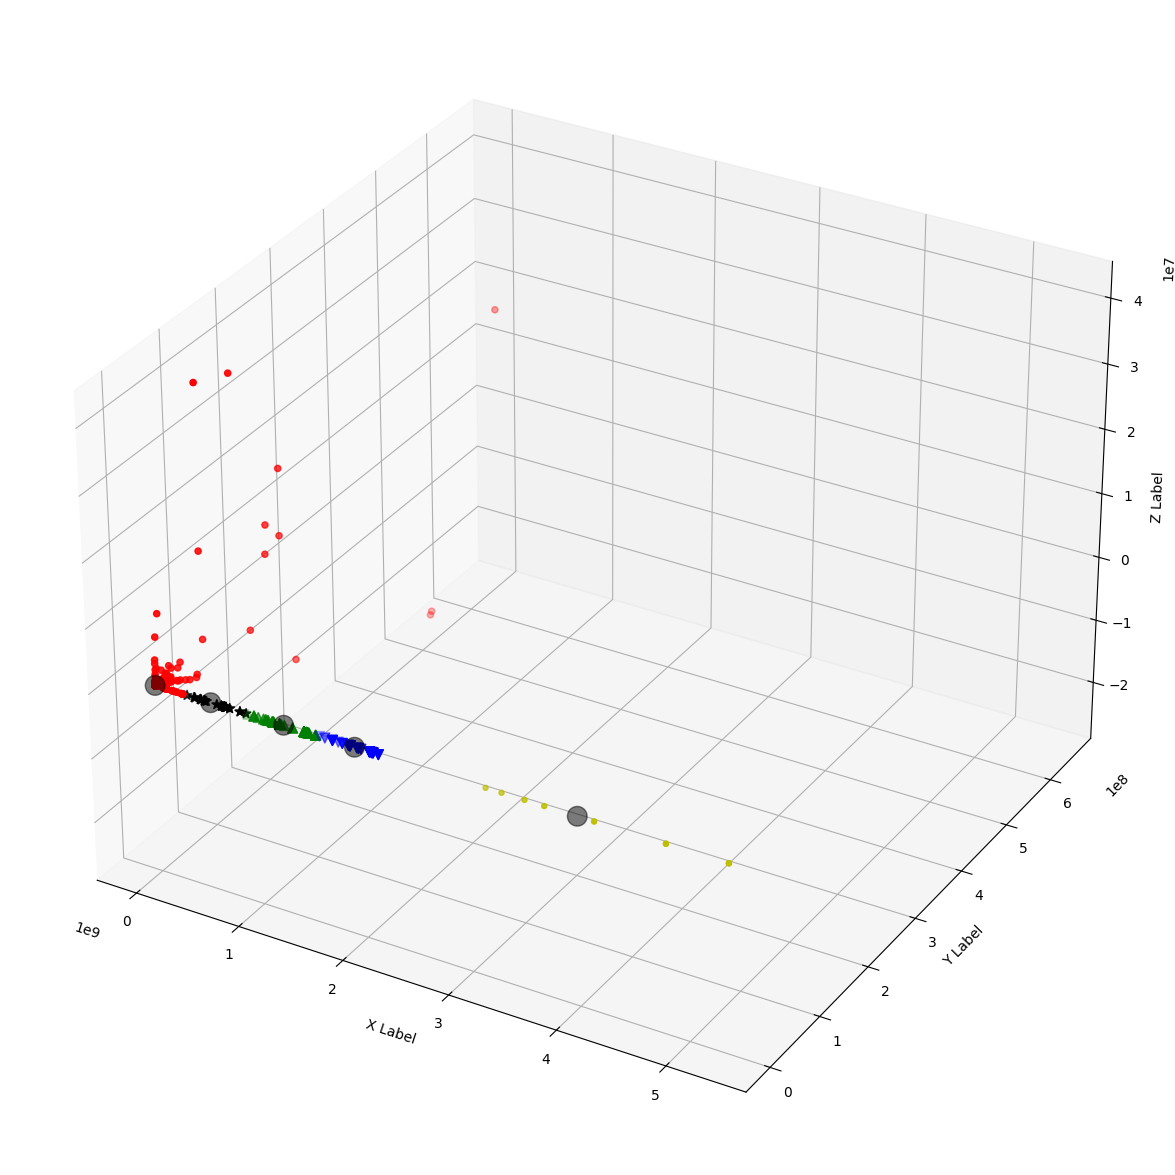

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
# Plot each cluster independently with different colors 
ax.scatter(reduced[y_kmeans==0, 0], reduced[y_kmeans==0, 1], reduced[y_kmeans==0, 2], c='r')
ax.scatter(reduced[y_kmeans==1, 0], reduced[y_kmeans==1, 1], reduced[y_kmeans==1, 2], s=50, c="g", marker="^")
ax.scatter(reduced[y_kmeans==2, 0], reduced[y_kmeans==2, 1], reduced[y_kmeans==2, 2], s=50, c="b", marker="v")
ax.scatter(reduced[y_kmeans==3, 0], reduced[y_kmeans==3, 1], reduced[y_kmeans==3, 2], s=50, c="y", marker=".")
ax.scatter(reduced[y_kmeans==4, 0], reduced[y_kmeans==4, 1], reduced[y_kmeans==4, 2], s=50, c="k", marker="*")

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=200, alpha=0.5, c='k', label = 'Centroids')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

While this is very interesting, you might be wondering, "But what were the principal components?  How do they map to my data?"  This is an excellent question.  Another question is, "Should the clusters look like that?"  Afterall, all of the clusters seem to fall along the $x$ axis.  This seems somewhat suspicious.

The PCA object that we have created has an element, `components_`, that returns an array representing the eigenvectors for each of the principal components.  Let's first look at them. 

# <img src="../images/task.png" width=20 height=20> Task 1.12

Please execute the following cell to print out the eigenvectors for our principal components using Pandas.  This cell assumes that your PCA object is in the variable `pca`.

In [15]:
pd.DataFrame(pca.components_, columns=df.columns, index=['PC-x', 'PC-y', 'PC-z'])

,sport,dport,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,proto_tcp,proto_udp
PC-x,0.000005,-0.000001,4.167819e-09,1.000000,0.000055,4.072163e-08,0.000012,5.063234e-08,0.000060,-2.989148e-11,4.331065e-11,-1.341917e-11
PC-y,0.000072,-0.000014,2.452742e-05,-0.000082,0.684226,2.572440e-04,0.055049,5.531954e-04,0.727189,-3.686506e-10,4.953672e-10,-1.267166e-10
PC-z,0.001128,-0.000200,5.875474e-04,-0.000008,-0.143811,2.647421e-03,0.987746,1.419158e-03,0.060539,-2.002961e-09,3.410610e-09,-1.407649e-09


What does this mean and how is it useful?  Locate the largest value found in each row and take note of the name of the column that it corresponds to.  In this case, we find that `orig_bytes` has the largest value for the first component, `resp_ip_bytes` is the largest for the second component, and `orig_ip_bytes` is the largest value in the third component.

Do not mistake this to mean that the `orig_bytes`, `resp_ip_bytes`, and `orig_ip_bytes` *are* the principal components, because they are not.  Each of these rows represents the eigenvector, or axis for each component in this twelve dimensional hyperspace.  However, it is accurate to say that these three values have the greatest *influence* over those components.

How is this useful?  In terms of understanding our data, we can see that we have three values, all related to the number of bytes, that are the principal values influencing our clustering (since we are reducing the data to just three components).  This might lead us to decide that we could choose to eliminate one, two, or all three of these values from our analysis, allowing other more subtle features to manifest.

# <img src="../images/task.png" width=20 height=20> Task 1.13

* Use the cell below to reload and reprocess the data.  
* When reprocessing the data, remove the `orig_bytes`, `orig_ip_bytes`, `resp_bytes`, and `resp_ip_bytes` from the dataframe.
* Apply an $\mathbb{R}^3$ PCA to the resulting data.
* Generate $5$ clusters using KMeans clustering.
* Regenerate the 3d scatter plot using the newly processed data.


In [16]:
def preprocess_data(df, drop_col):
    df = pd.concat([df, pd.get_dummies(df['proto'], prefix='proto')], axis=1)
    df.drop(df.index[-1], inplace=True) #Drop the last row using -1 index
    df.drop(columns=drop_col, inplace=True)
    # Remove the additional columns
    df.drop(columns=['orig_bytes', 'resp_bytes', 'orig_ip_bytes', 'resp_ip_bytes'], inplace=True)
    df.proto_icmp = df.proto_icmp.replace({True: 1, False: 0})
    df.proto_tcp = df.proto_tcp.replace({True: 1, False: 0})
    df.proto_udp = df.proto_udp.replace({True: 1, False: 0})
    df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')
    data = df.to_numpy()
    for i in np.argwhere(np.isnan(data)):
        data[i[0],i[1]] = 0
    return data

In [17]:
def plot_clusters(data):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(reduced[y_kmeans==0, 0], reduced[y_kmeans==0, 1], reduced[y_kmeans==0, 2], c='r')
    ax.scatter(reduced[y_kmeans==1, 0], reduced[y_kmeans==1, 1], reduced[y_kmeans==1, 2], s=50, c="g", marker="^")
    ax.scatter(reduced[y_kmeans==2, 0], reduced[y_kmeans==2, 1], reduced[y_kmeans==2, 2], s=50, c="b", marker="v")
    ax.scatter(reduced[y_kmeans==3, 0], reduced[y_kmeans==3, 1], reduced[y_kmeans==3, 2], s=50, c="y", marker=".")
    ax.scatter(reduced[y_kmeans==4, 0], reduced[y_kmeans==4, 1], reduced[y_kmeans==4, 2], s=50, c="k", marker="*")
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=200, alpha=0.5, c='k', label = 'Centroids')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    return plt    

Reading Data...


/tmp/ipykernel_13942/1246189746.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8,


Processing Raw Data...
Calculating PCA...
Fitting K-Means Cluster...
385862
409285
357253
46073
121487


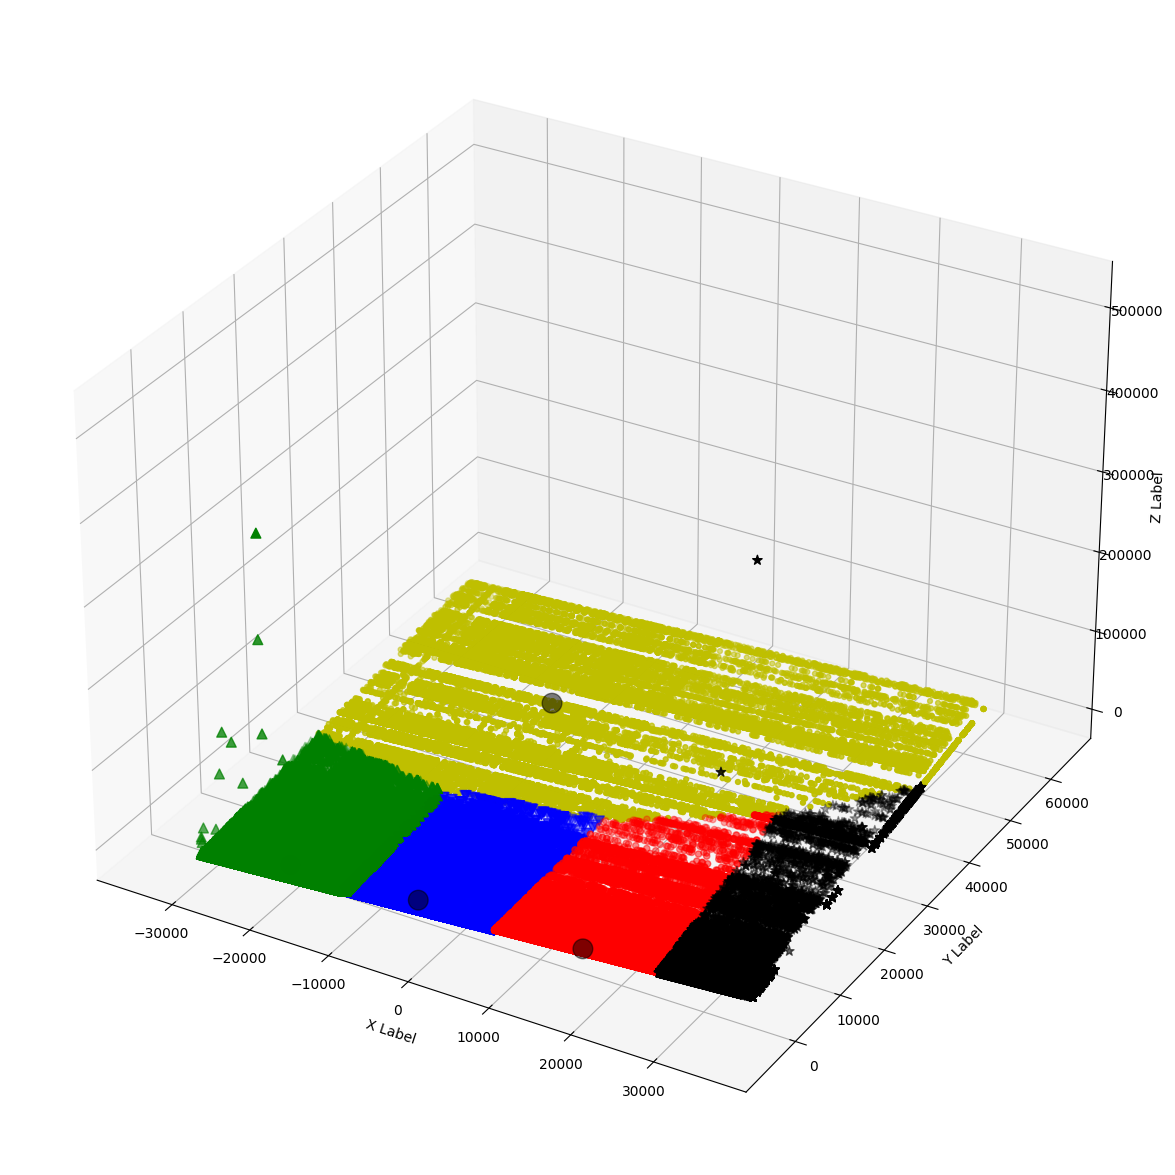

In [18]:
print("Reading Data...")
df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8,
        names=['timestamp','uid','src','sport','dst','dport','proto','service','duration','orig_bytes', 
               'resp_bytes','conn_state','local_orig','local_resp','missed_bytes','history','orig_pkts', 
               'orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents'])
print("Processing Raw Data...")
data= preprocess_data(df, drop_col)
print("Calculating PCA...")
pca = PCA(3)
pca.fit(data)
reduced = pca.transform(data)

print("Fitting K-Means Cluster...")
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
kmeans.fit(reduced)
y_kmeans = kmeans.predict(reduced)
for i in range (5):
    print(len(reduced[y_kmeans==i]))
    
plt = plot_clusters(data)
plt.show()

There have been some very significant changes to our output!  There is still a very big question as to whether $5$ clusters is the right number to use, but the data now appears to be mostly in a plane.  Of course, if we were able to easily rotate this, we may find that it is not as flat as it first appears, but removing those dominating features has definitely made a difference.

## Scaling Data

Still, there might be an even better approach.  Could it be that the features that we have dropped out are important, but since the values were so much larger in magnitude than other values, they ended up dominating the transformation?  This seems very reasonable.  How can we address this?

A very practical approach is to scale the data.  There are many approaches that can be used to scale our data.  For example, we might take the features that we removed and replace the values with the $log(x)$ of each.  This would bring the scale of the values down dramatically.

Another approach might be to take the square root of each value.  This, too, would reduce the magnitude significantly.

Yet another approach would be to use a "Min-Max Scaler", which uses the ration of the minimum and maximum values to scale all of the data to values between $0$ and $1$.

We, however, will use the `StandardScaler` class within SciKit Learn.  This scaler replaces each value with:

$$x = \frac{x - \bar{x}}{\sigma ^2}$$

That is, all of the values are mapped into the range $[-1,1]$ and centered on $0$.  Effectively, we are mapping them into approximately a Gaussian distribution centered on $0$.

# <img src="../images/task.png" width=20 height=20> Task 1.14

* Use the cell below to reload and reprocess the data.  
* Remove only the *originally* excluded features.
* Import and instantiate a `StandardScaler()` object.
* Use the `StandardScaler()` object to `fit()` the data.
* Use the fitted `scaler` object to `transform()` the data.
* Apply an $\mathbb{R}^3$ PCA to the resulting data.
* Generate $5$ clusters using KMeans clustering.
* Regenerate the 3d scatter plot using the newly processed data.

Reading Data...


/tmp/ipykernel_13942/1302172502.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8, \


Processing Data...
Fitting KMeans
1196651
85084
38212
12
1


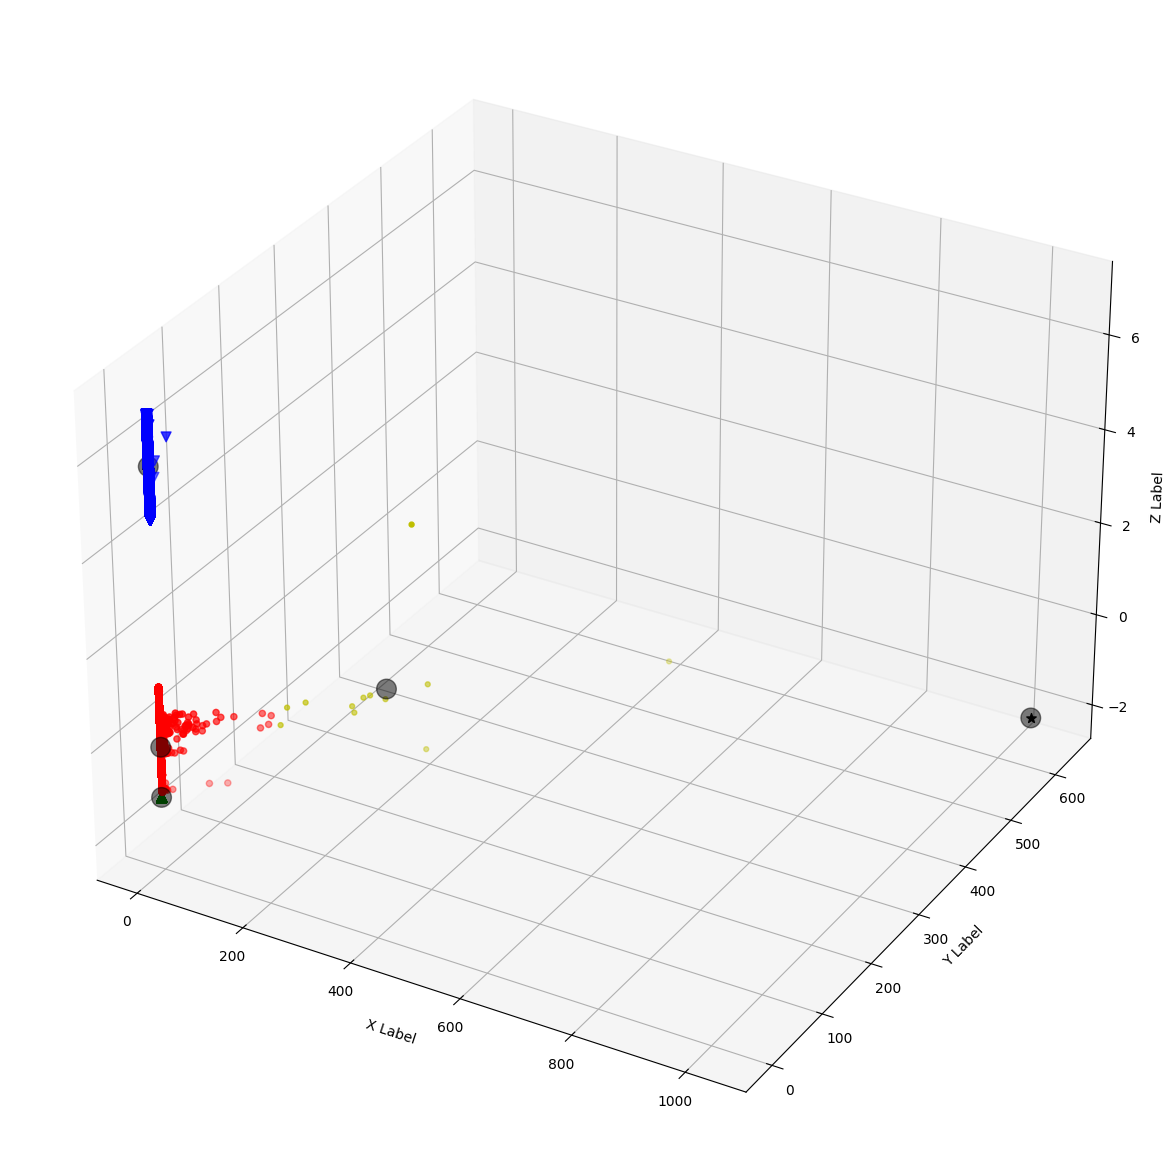

In [19]:
print("Reading Data...")
df = pd.read_csv("../data/Day 3/conn.log", sep="\t", skiprows=8, \
        names=['timestamp','uid','src','sport','dst','dport','proto','service','duration','orig_bytes', \
               'resp_bytes','conn_state','local_orig','local_resp','missed_bytes','history','orig_pkts', \
               'orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents'])
print("Processing Data...")
data = preprocess_data(df, drop_col)
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
pca = PCA(3)
pca.fit(scaled)
reduced = pca.transform(scaled)
print("Fitting KMeans")
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
kmeans.fit(reduced)
y_kmeans = kmeans.predict(reduced)
for i in range (5):
    print(len(reduced[y_kmeans==i]))
plt = plot_clusters(data)
plt.show()

Wow!  What a difference that made!  Notice that there are now at least two very clear clusters in addition to a variety of other values that are fairly distant from the cluster centers.  How many clusters *should* there be?  We don't yet know.  We'll explore and solve this problem in the next lab.

# Conclusion

In this lab, we have had the opportunity to explore our data and gain some insights into relationships within the data.  We saw how K-Means clustering can be used to identify similarities, creating clusters, and how Principal Component Analysis can be used for dimensionality reduction.  This leads to a natural mechanism for visualizing our data.

While we know that we can inspect a visualization of our data and, from that, determine how many clusters we see, we have yet to see an algorithmic means to accomplish this.  We will address this problem next.

In [20]:
#!pip install clusteval

In [21]:
from clusteval import clusteval

# Set parameters, as an example kmeans with silhouette evaluation
ce = clusteval(cluster='kmeans', evaluate='silhouette')


In [22]:
res = data[0:500]
# Fit to find optimal number of clusters using dbscan
results= ce.fit(res)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|                                 | 0/23 [00:00<?, ?it/s]/home/matt/my_python_env/AI/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/matt/my_python_env/AI/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
[clusteval] >INFO:   9%|██▏                      | 2/23 [00:00<00:01, 15.12it/s]/home/matt/my_python_env/AI/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: Futu

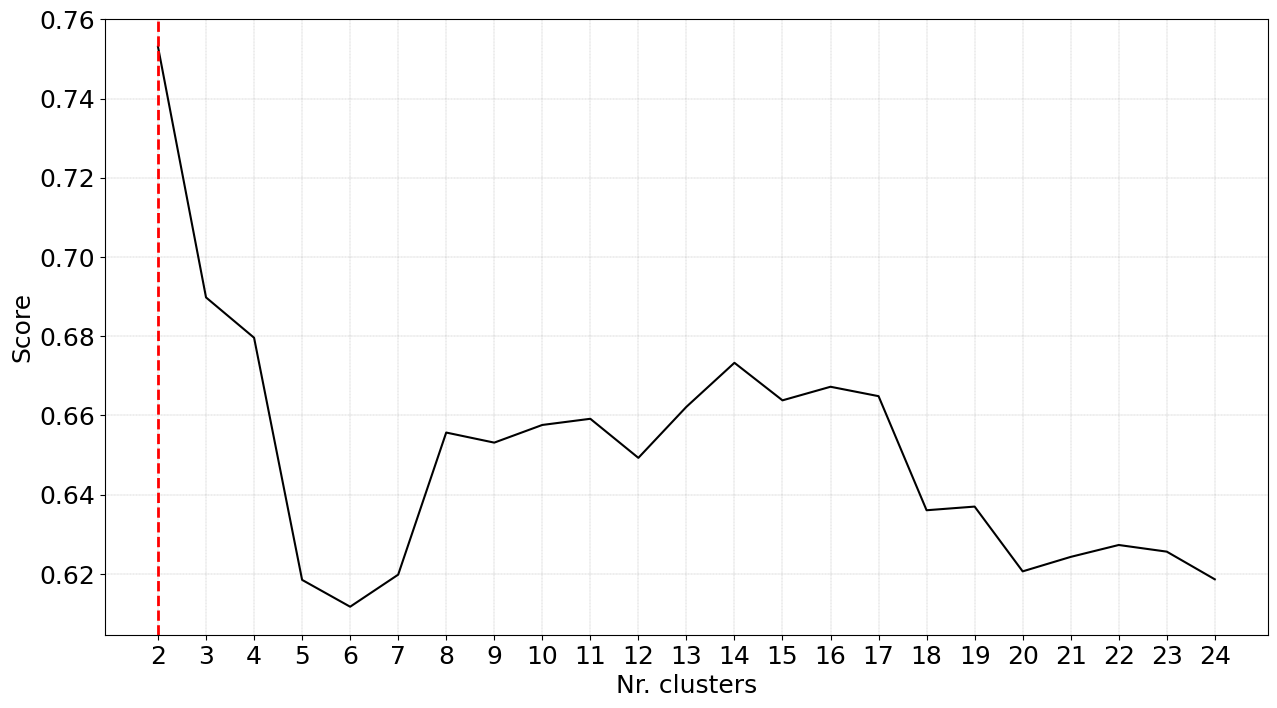

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


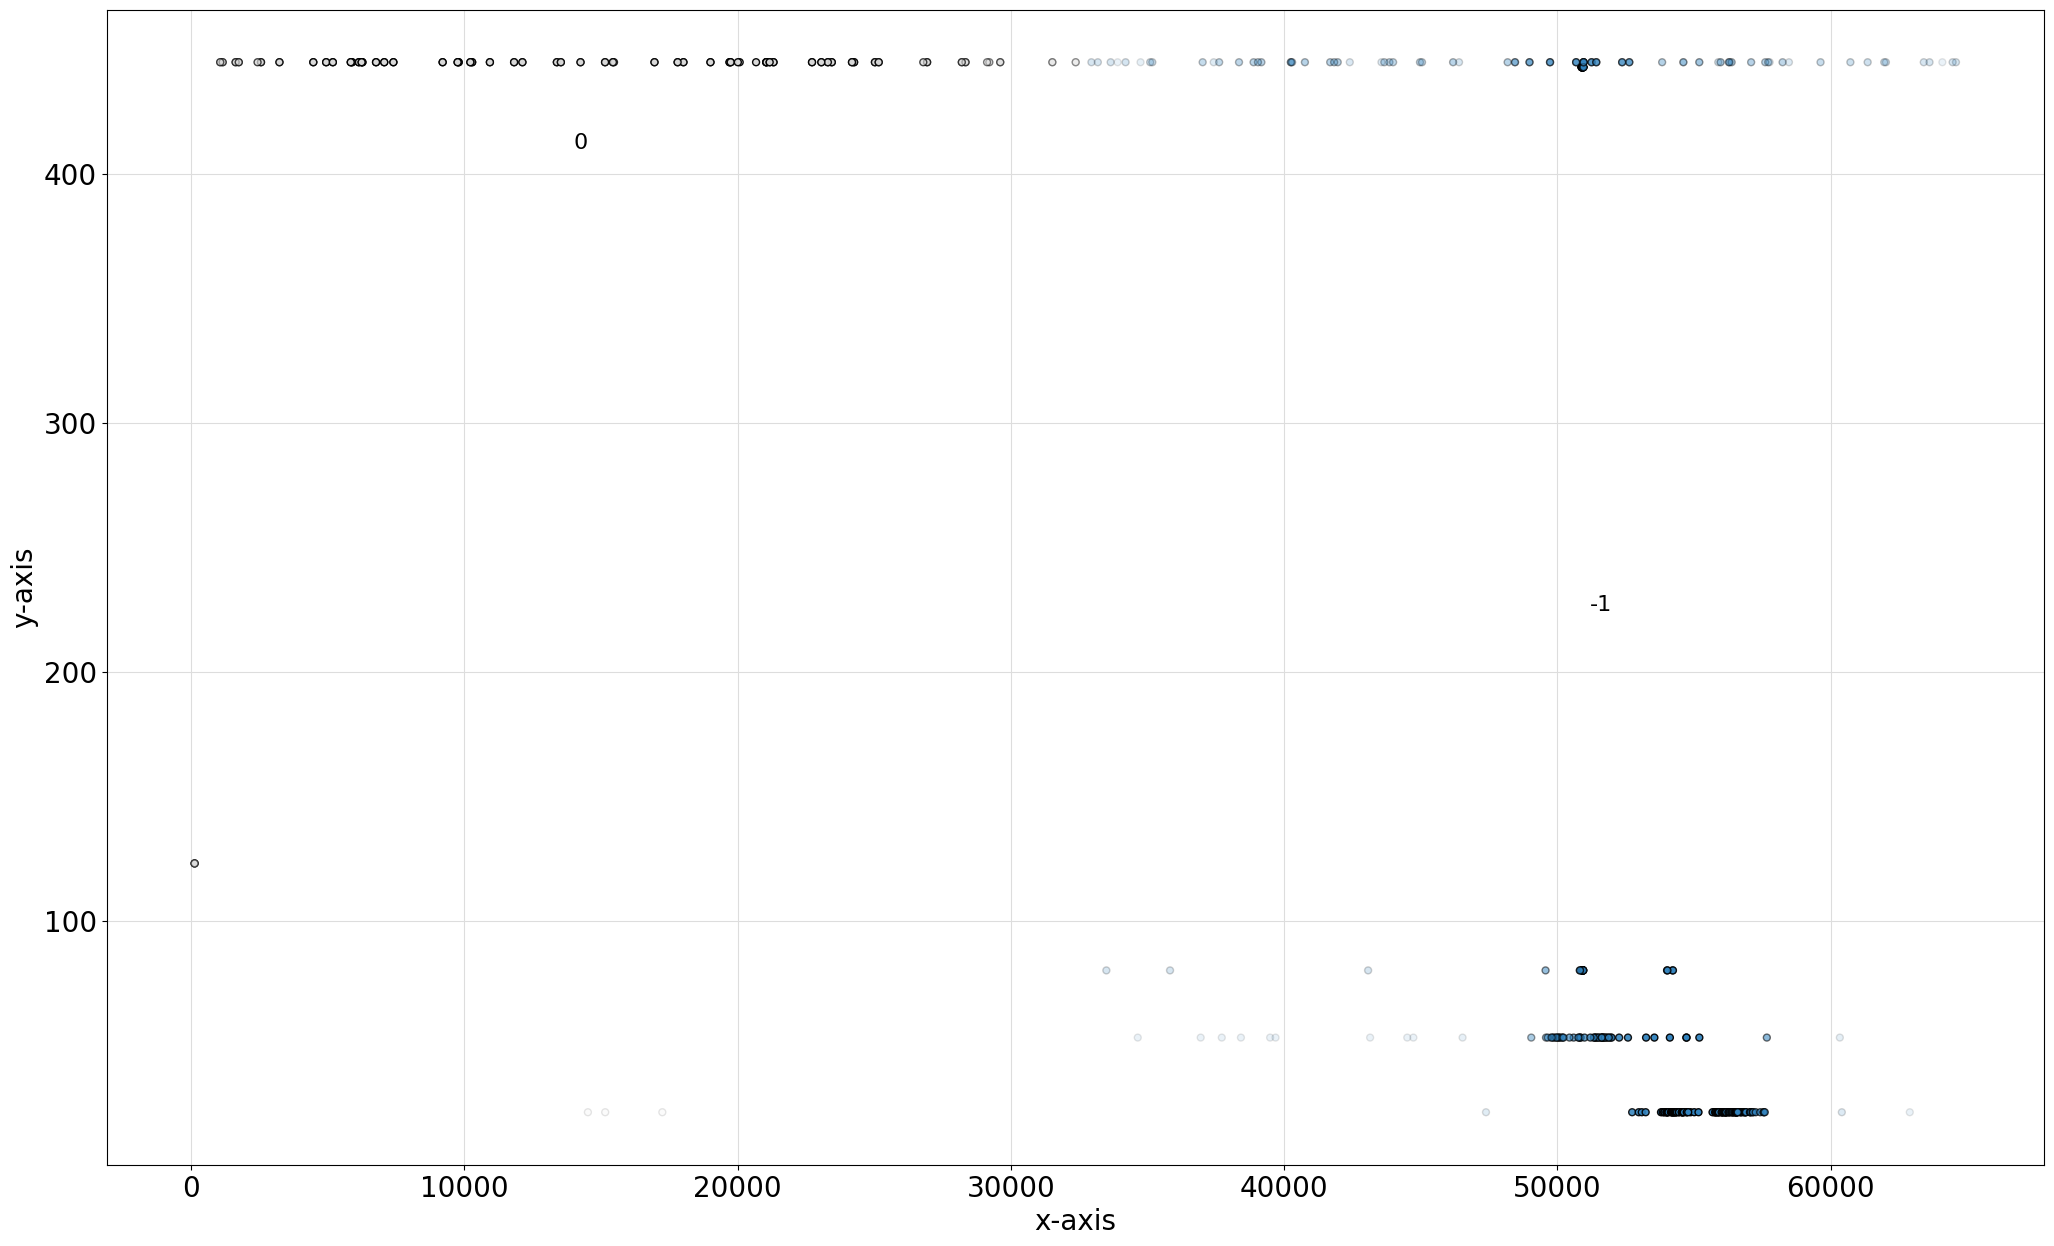

In [23]:
# Make plot of the cluster evaluation
ce.plot()
# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(res)
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']